In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import skimage.io as io
import skimage.filters as flt
from skimage.metrics import structural_similarity as SSIM
%matplotlib inline
# since we can't use imports
import numpy as np
import scipy.ndimage.filters as flt
import warnings
import cv2
from glob import glob 

import pylab as pl
from time import sleep
import tensorflow as tf
from tqdm import tqdm
from collections import Counter

CROP = 256

In [2]:
def anisodiff(img,niter=1,lambd=50,gamma=0.1,step=(1.,1.),sigma=0, option=1,ploton=False):

    img = img.astype('float32')
    imgout = img.copy()

    deltaS = np.zeros_like(imgout)
    deltaE = deltaS.copy()
    NS = deltaS.copy()
    EW = deltaS.copy()
    gS = np.ones_like(imgout)
    gE = gS.copy()

    if ploton:

        fig = pl.figure(figsize=(20,5.5),num="Anisotropic diffusion")
        ax1,ax2 = fig.add_subplot(1,2,1),fig.add_subplot(1,2,2)

        ax1.imshow(img,interpolation='nearest')
        ih = ax2.imshow(imgout,interpolation='nearest',animated=True)
        ax1.set_title("Original image")
        ax2.set_title("Iteration 0")

        fig.canvas.draw()

    for ii in np.arange(1,niter):

        deltaS[:-1,: ] = np.diff(imgout,axis=0)
        deltaE[: ,:-1] = np.diff(imgout,axis=1)

        if 0<sigma:
            deltaSf=flt.gaussian_filter(deltaS,sigma);
            deltaEf=flt.gaussian_filter(deltaE,sigma);
        else: 
            deltaSf=deltaS;
            deltaEf=deltaE;

        if option == 1:
            gS = np.exp(-(deltaSf/lambd)**2.)/step[0]
            gE = np.exp(-(deltaEf/lambd)**2.)/step[1]
        elif option == 2:
            gS = 1./(1.+(deltaSf/lambd)**2.)/step[0]
            gE = 1./(1.+(deltaEf/lambd)**2.)/step[1]
        elif option == 3:
            gS = lambd/step[0]
            gE = lambd/step[1]

        E = gE*deltaE
        S = gS*deltaS

        NS[:] = S
        EW[:] = E
        NS[1:,:] -= S[:-1,:]
        EW[:,1:] -= E[:,:-1]


        imgout += gamma*(NS+EW)

        if ploton:
            iterstring = "Iteration %i" %(ii+1)
            ih.set_data(imgout)
            ax2.set_title(iterstring)
            fig.canvas.draw()

            

    return imgout

# Examining data set

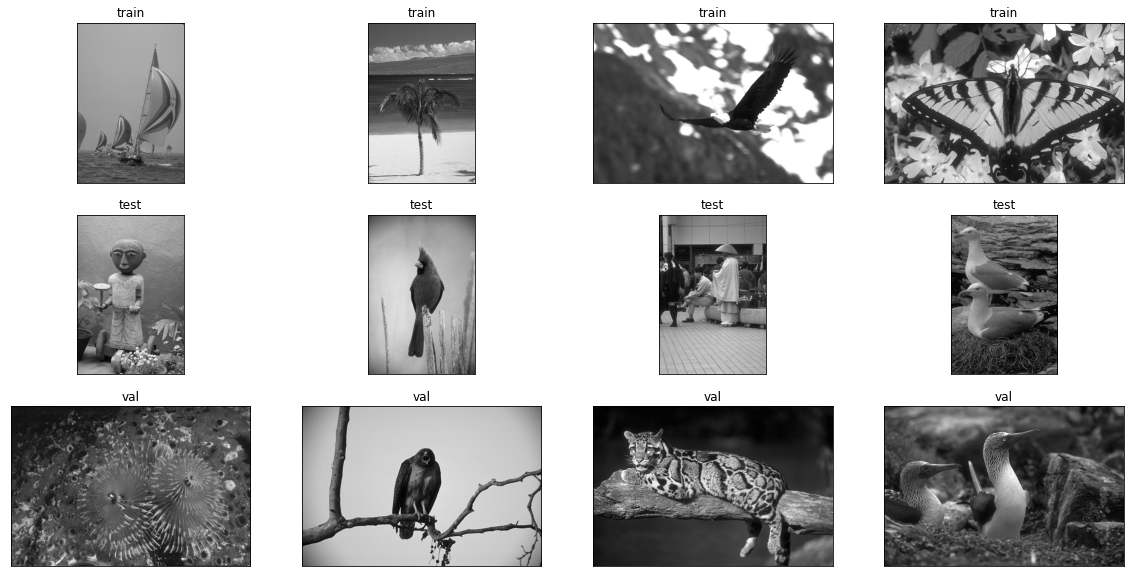

In [3]:
ncols = 4
nrows = 3

fig,axs = plt.subplots(nrows = nrows,ncols = ncols,figsize=(20,10))
test = glob('../images/test/*.jpg')
train = glob('../images/train/*.jpg')
val = glob('../images/val/*.jpg')

imgs = [train,test,val]
titles = ['train','test','val']

for i in range(len(imgs)):
    for j in range(ncols):
        _ = np.random.choice(imgs[i])
        axs[i,j].imshow(cv2.imread(_,cv2.IMREAD_GRAYSCALE),cmap = 'gray')
        axs[i,j].set_xticks([])
        axs[i,j].set_xticklabels([])
        axs[i,j].set_yticks([])
        axs[i,j].set_yticklabels([])
        axs[i,j].set_title(titles[i])
        
        
plt.show()

# Poisson

In [4]:
def open_frame_poisson(frame_num,var=1):
    input_path = frame_num
    
    img = np.asarray(cv2.cvtColor(cv2.imread(input_path), cv2.COLOR_BGR2GRAY), dtype=np.float32)
    #img = cv2.resize(img,(CROP,CROP)
    input_channel = img/np.amax(img)
    poisson_noise = np.sqrt(img) * np.random.normal(0, var, img.shape)
    
    poisson = img + poisson_noise
    
    
    return input_channel,poisson



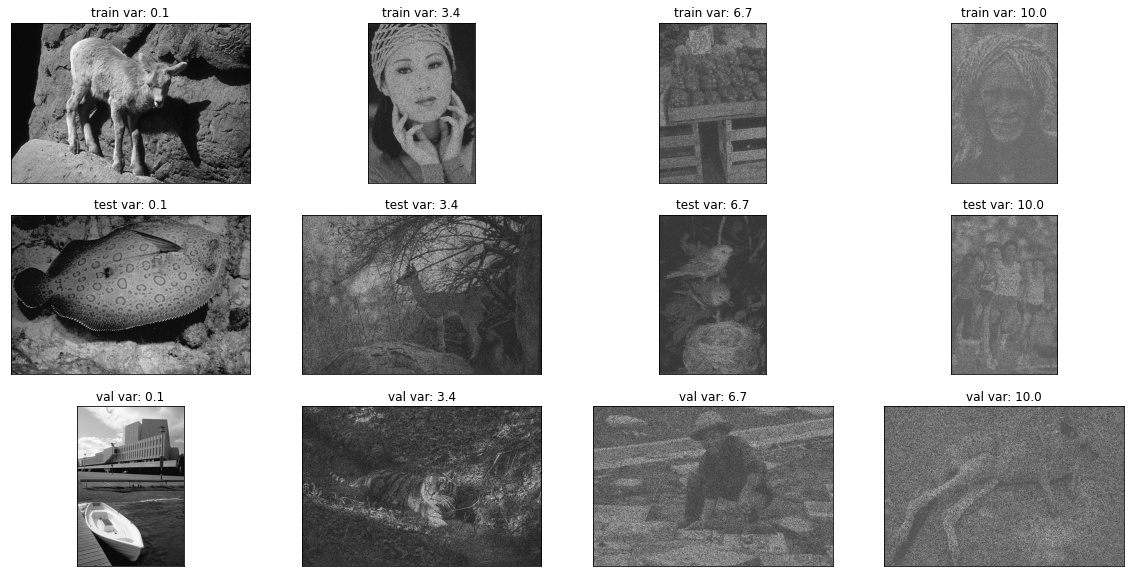

In [14]:
ncols = 4
nrows = 3

fig,axs = plt.subplots(nrows = nrows,ncols = ncols,figsize=(20,10))
test = glob('../images/test/*.jpg')
train = glob('../images/train/*.jpg')
val = glob('../images/val/*.jpg')

imgs = [train,test,val]
titles = ['train','test','val']
var = np.trunc(1e3*np.linspace(0.1,10,ncols))/1e3

for i in range(len(imgs)):
    for j in range(ncols):
        _ = np.random.choice(imgs[i])
        im = open_frame_poisson(_,var[j])
        axs[i,j].imshow(im[1],cmap = 'gray')
        axs[i,j].set_xticks([])
        axs[i,j].set_xticklabels([])
        axs[i,j].set_yticks([])
        axs[i,j].set_yticklabels([])
        axs[i,j].set_title(f'{titles[i]} var: {var[j]}')
        
        
plt.show()

## opinion 1

100%|██████████████████████████████████████| 10/10 [22:26:37<00:00, 8079.71s/it]


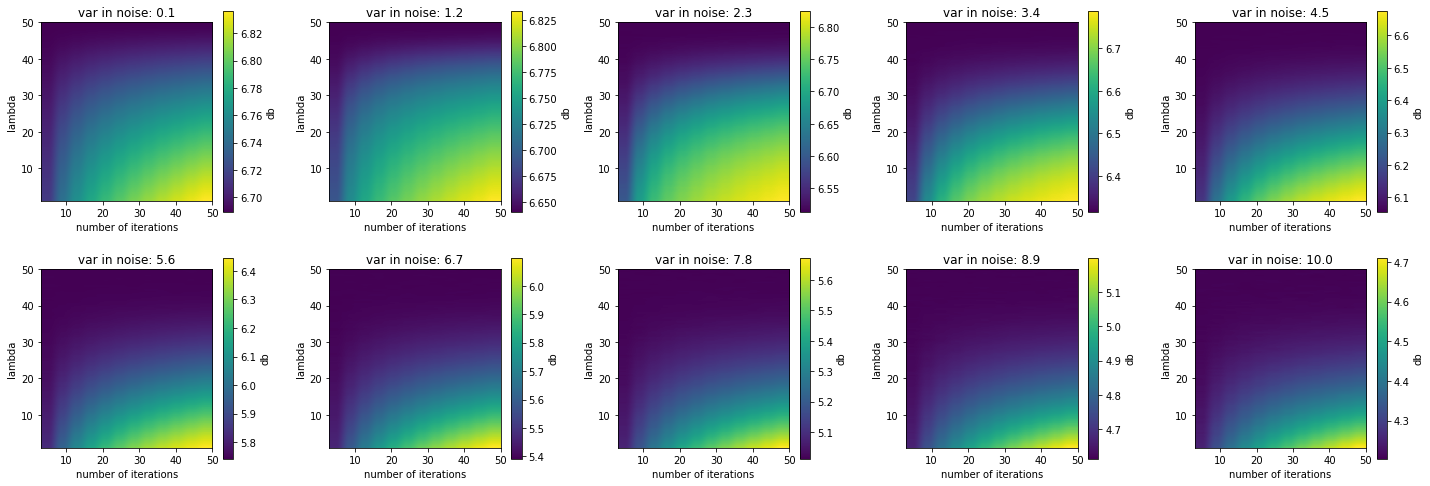

In [16]:
ncols,nrows = 5,2
var = np.trunc(1e3*np.linspace(0.1,10,ncols*nrows))/1e3
V = []
for j in tqdm(range(len(var))):
    K = []
    for lambd in np.linspace(1,50,100):
        psnr = []
        for it in np.arange(3,50,4):
            er = []
            for _ in train:
                x,y = open_frame_poisson(_,var[j])
                y = anisodiff(y,niter=it,lambd=lambd)
                er.append(cv2.PSNR(x,y))
            psnr.append(np.mean(er))
        K.append(psnr)
    V.append(K)
    
np.save('/home/joel/nci-storage/fly_group_behavior/scripts/PeronaMalik/thesis/11_oct/option_1_poisson.npy',np.array(V))


fig,axs = plt.subplots(ncols=ncols,nrows=nrows,figsize=(20,7))

for i in range(len(V)):
    im = axs[i//ncols,i%ncols].imshow(V[i],extent=[3,50,1,50])
    plt.colorbar(im,ax=axs[i//ncols,i%ncols],label='db')
    axs[i//ncols,i%ncols].set_xlabel('number of iterations')
    axs[i//ncols,i%ncols].set_ylabel('lambda')
    axs[i//ncols,i%ncols].set_title(f'var in noise: {var[i]}')
    
plt.tight_layout()
plt.show()

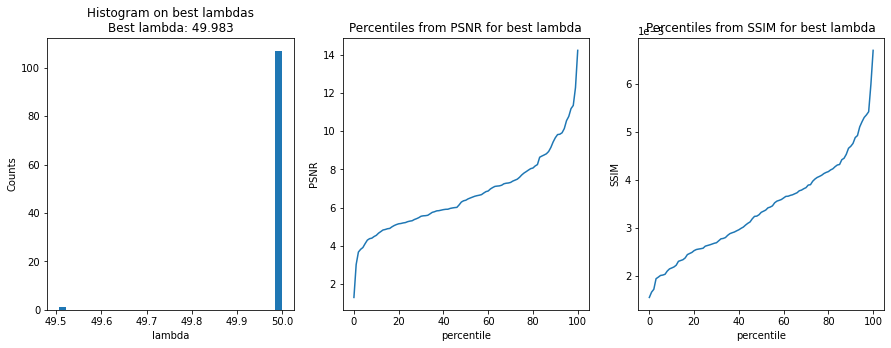

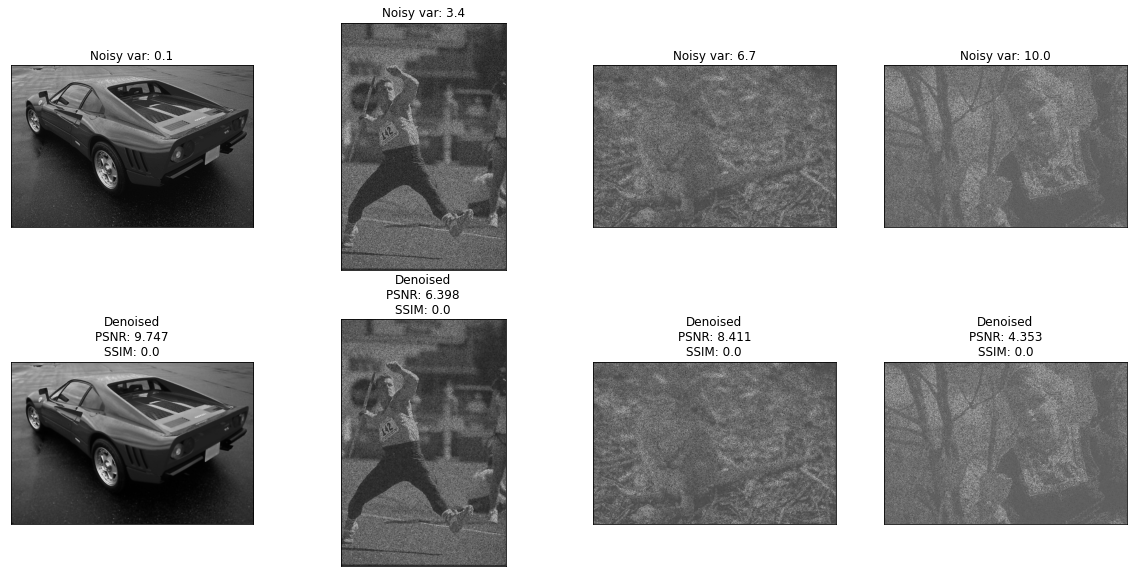

In [17]:
psnr,ssim = [],[]
for _ in test:
    im = open_frame_poisson(_)
    psnr.append(cv2.PSNR(im[0],anisodiff(im[1],option=1)))
    ssim.append(SSIM(im[0],anisodiff(im[1],option=1)))

plt.figure(figsize=(15,5))
plt.subplot(131)
plt.hist(np.linspace(1,50,100)[np.argmax(V[1:],axis=1).flatten()],bins=30)
hist = np.histogram(np.linspace(1,50,100)[np.argmax(V[1:],axis=1).flatten()],bins=30)
best = np.trunc(1e3*hist[1][np.argmax(hist[0])])/1e3
plt.xlabel('lambda')
plt.ylabel('Counts')
plt.title(f'Histogram on best lambdas\nBest lambda: {best}')

plt.subplot(132)
plt.plot(np.percentile(psnr,q=np.arange(0,101,1)))
plt.xlabel('percentile')
plt.ylabel('PSNR')
plt.title('Percentiles from PSNR for best lambda')

plt.subplot(133)
plt.plot(np.percentile(ssim,q=np.arange(0,101,1)))
plt.xlabel('percentile')
plt.ylabel('SSIM')
plt.title('Percentiles from SSIM for best lambda')

plt.show()

ncols = 4
nrows = 2

fig,axs = plt.subplots(nrows = nrows,ncols = ncols,figsize=(20,10))
test = glob('../images/test/*.jpg')
train = glob('../images/train/*.jpg')
val = glob('../images/val/*.jpg')

var = np.trunc(1e3*np.linspace(0.1,10,ncols))/1e3


for j in range(ncols):
    _ = np.random.choice(test)
    im = open_frame_poisson(_,var[j])
    denoised = anisodiff(im[1],niter=5,lambd=best,option=1)
    axs[0,j].imshow(im[1],cmap = 'gray')
    axs[0,j].set_xticks([])
    axs[0,j].set_xticklabels([])
    axs[0,j].set_yticks([])
    axs[0,j].set_yticklabels([])
    axs[0,j].set_title(f'Noisy var: {var[j]}')
    
    axs[1,j].imshow(denoised,cmap = 'gray')
    axs[1,j].set_xticks([])
    axs[1,j].set_xticklabels([])
    axs[1,j].set_yticks([])
    axs[1,j].set_yticklabels([])
    axs[1,j].set_title(f'Denoised\nPSNR: {np.trunc(1e3*cv2.PSNR(im[0],denoised))/1e3}\nSSIM: {np.trunc(1e3*SSIM(im[0],denoised))/1e3}')
        
        
plt.show()

## option 2

100%|██████████████████████████████████████| 10/10 [14:49:50<00:00, 5339.01s/it]


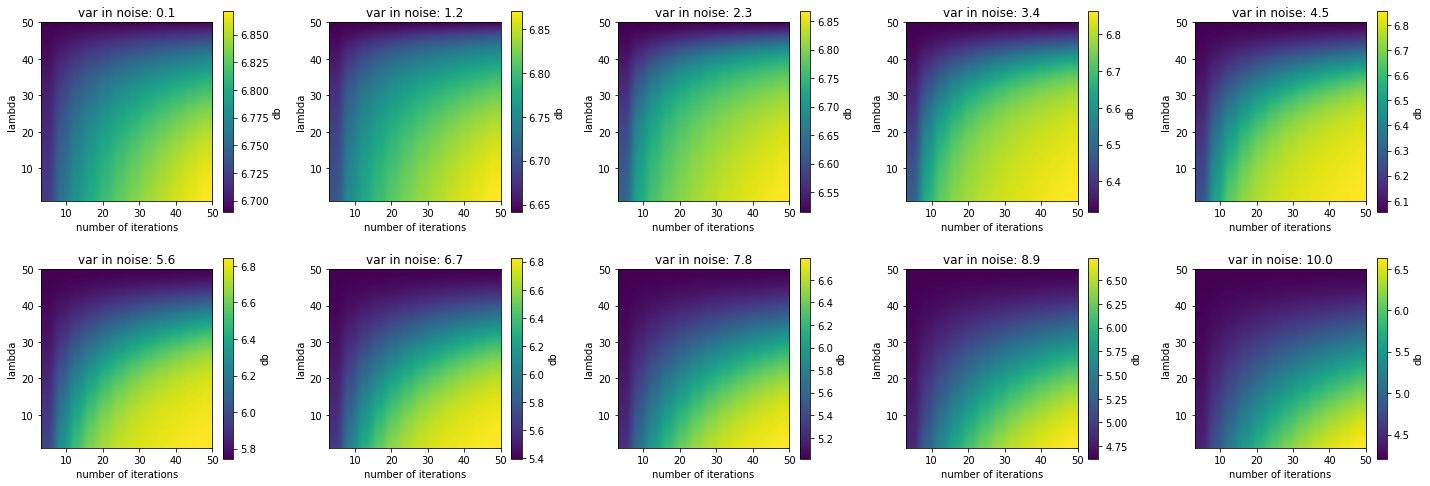

In [18]:
ncols,nrows = 5,2
var = np.trunc(1e3*np.linspace(0.1,10,ncols*nrows))/1e3
V = []
for j in tqdm(range(len(var))):
    K = []
    for lambd in np.linspace(1,50,100):
        psnr = []
        for it in np.arange(3,50,4):
            er = []
            for _ in train:
                x,y = open_frame_poisson(_,var[j])
                y = anisodiff(y,niter=it,lambd=lambd,option=2)
                er.append(cv2.PSNR(x,y))
            psnr.append(np.mean(er))
        K.append(psnr)
    V.append(K)
    
np.save('/home/joel/nci-storage/fly_group_behavior/scripts/PeronaMalik/thesis/11_oct/option_2_poisson.npy',np.array(V))


fig,axs = plt.subplots(ncols=ncols,nrows=nrows,figsize=(20,7))

for i in range(len(V)):
    im = axs[i//ncols,i%ncols].imshow(V[i],extent=[3,50,1,50])
    plt.colorbar(im,ax=axs[i//ncols,i%ncols],label='db')
    axs[i//ncols,i%ncols].set_xlabel('number of iterations')
    axs[i//ncols,i%ncols].set_ylabel('lambda')
    axs[i//ncols,i%ncols].set_title(f'var in noise: {var[i]}')
    
plt.tight_layout()
plt.show()

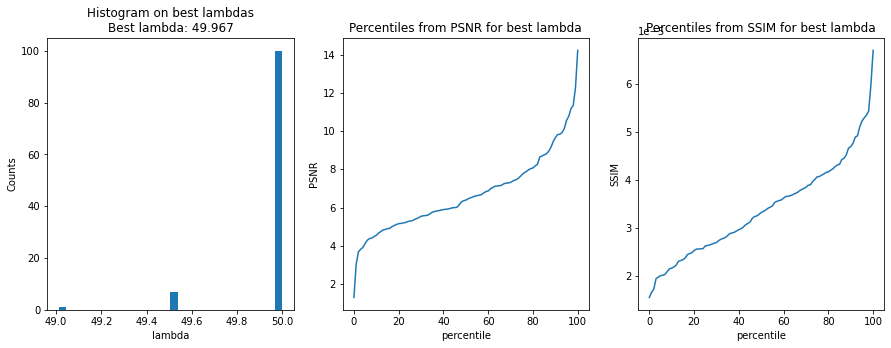

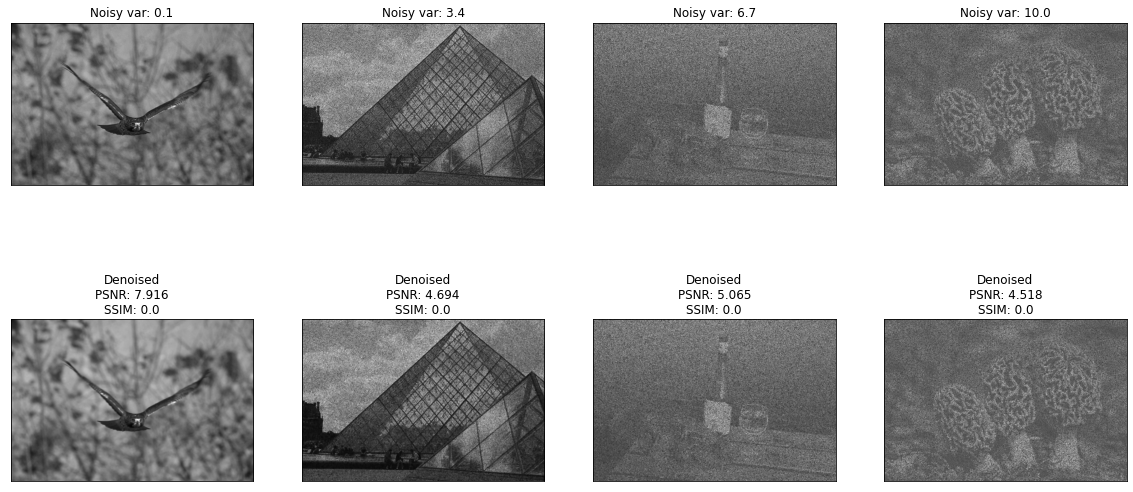

In [19]:
psnr,ssim = [],[]
for _ in test:
    im = open_frame_poisson(_)
    psnr.append(cv2.PSNR(im[0],anisodiff(im[1],option=2)))
    ssim.append(SSIM(im[0],anisodiff(im[1],option=2)))

plt.figure(figsize=(15,5))
plt.subplot(131)
plt.hist(np.linspace(1,50,100)[np.argmax(V[1:],axis=1).flatten()],bins=30)
hist = np.histogram(np.linspace(1,50,100)[np.argmax(V[1:],axis=1).flatten()],bins=30)
best = np.trunc(1e3*hist[1][np.argmax(hist[0])])/1e3
plt.xlabel('lambda')
plt.ylabel('Counts')
plt.title(f'Histogram on best lambdas\nBest lambda: {best}')

plt.subplot(132)
plt.plot(np.percentile(psnr,q=np.arange(0,101,1)))
plt.xlabel('percentile')
plt.ylabel('PSNR')
plt.title('Percentiles from PSNR for best lambda')

plt.subplot(133)
plt.plot(np.percentile(ssim,q=np.arange(0,101,1)))
plt.xlabel('percentile')
plt.ylabel('SSIM')
plt.title('Percentiles from SSIM for best lambda')

plt.show()

ncols = 4
nrows = 2

fig,axs = plt.subplots(nrows = nrows,ncols = ncols,figsize=(20,10))
test = glob('../images/test/*.jpg')
train = glob('../images/train/*.jpg')
val = glob('../images/val/*.jpg')

var = np.trunc(1e3*np.linspace(0.1,10,ncols))/1e3


for j in range(ncols):
    _ = np.random.choice(test)
    im = open_frame_poisson(_,var[j])
    denoised = anisodiff(im[1],niter=5,lambd=best,option=2)
    axs[0,j].imshow(im[1],cmap = 'gray')
    axs[0,j].set_xticks([])
    axs[0,j].set_xticklabels([])
    axs[0,j].set_yticks([])
    axs[0,j].set_yticklabels([])
    axs[0,j].set_title(f'Noisy var: {var[j]}')
    
    axs[1,j].imshow(denoised,cmap = 'gray')
    axs[1,j].set_xticks([])
    axs[1,j].set_xticklabels([])
    axs[1,j].set_yticks([])
    axs[1,j].set_yticklabels([])
    axs[1,j].set_title(f'Denoised\nPSNR: {np.trunc(1e3*cv2.PSNR(im[0],denoised))/1e3}\nSSIM: {np.trunc(1e3*SSIM(im[0],denoised))/1e3}')
        
        
plt.show()